In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pyhf
import pyhf.readxml
from ipywidgets import interact, fixed

# Binned HEP Statistical Analysis in Python

## HistFactory

HistFactory is a popular framework to analyze binned event data and commonly used in High Energy Physics. At its core it is a template for building a statistical model from individual binned distribution ('Histograms') and variations on them ('Systematics') that represent auxiliary measurements (for example an energy scale of the detector which affects the shape of a distribution)

## pyhf

`pyhf` is a work-in-progress standalone implementation of the HistFactory p.d.f. template and an implementation of the test statistics and asymptotic formulae described in the paper by Cowan, Cranmer, Gross, Vitells: *Asymptotic formulae for likelihood-based tests of new physics* [[arxiv:1007.1727](https://arxiv.org/abs/1007.1727)].

Models can be defined using JSON specification, but existing models based on the XML + ROOT file scheme are readable as well.

## The Demo

The input data for the statistical analysis was built generated using the containerized workflow engine [yadage](https://github.com/diana-hep/yadage) (see demo from KubeCon 2018 [[youtube](https://github.com/diana-hep/yadage)]). Similarly to Binder this utilizes modern container technology for reproducible science. Below you see the execution graph leading up to the model input data at the bottom.


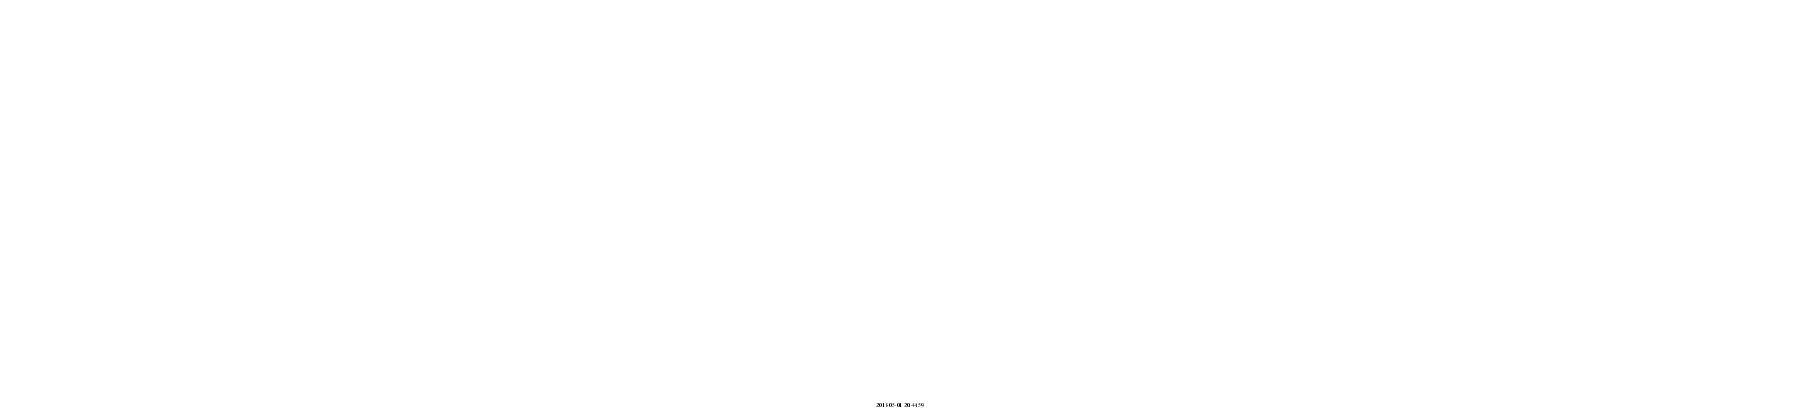

In [3]:
import base64
from IPython.core.display import display, HTML
anim = base64.b64encode(open('workflow.gif','rb').read()).decode('ascii')
HTML('<img src="data:image/gif;base64,{}">'.format(anim))

## Read in the Model from XML and ROOT

The ROOT files are read using scikit-hep's [uproot](https://github.com/scikit-hep/uproot) module.

In [4]:
parsed = pyhf.readxml.parse('meas.xml',os.getcwd())
obs_data = parsed['data']['channel1'] 

From the parsed data, we construct a probability density function (p.d.f). As the model includes systematics a number of implied "auxiliary measurements" must be added to the observed data distribution.

In [5]:
pdf = pyhf.Model({'channels': parsed['channels']}, poiname = 'SigXsecOverSM')
data = obs_data + pdf.config.auxdata

The p.d.f is build from one data-drived "qcd" (or multijet) estimate and two Monte Carlo-based background samples and is parametrized by five parameters: One parameter of interest `SigXsecOverSM` and four *nuisance parameters* that affect the shape of the two Monte Carlo background estimates (both weight-only and shape systematics)

In [6]:
c = pdf.spec['channels'][0]
sample_names = [s['name'] for s in c['samples']]
par_name_dict = {k: v['slice'].start for k,v in pdf.config.par_map.items()}

print('Samples:\n {}'.format(sample_names))
print('Parameters:\n {}'.format(par_name_dict))

Samples:
 ['signal', 'qcd', 'mc1', 'mc2']
Parameters:
 {'SigXsecOverSM': 0, 'mc1_weight_var1': 1, 'mc1_shape_conv': 2, 'mc2_weight_var1': 3, 'mc2_shape_conv': 4}


In [7]:
def plot(ax=None, order=[1, 2, 3, 0], **par_settings):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(10, 5)
        ax.set_ylim(0, 1.5 * np.max(obs_data))
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k,v in par_settings.items():
        pars[par_name_dict[k]] = v
    mc_counts = [pdf.expected_sample(c,s, pars) for s in [c['samples'][o] for o in order]]
    bottom = None
    for i,bar_data in enumerate(mc_counts):
        x = np.arange(len(bar_data))
        p1 = ax.bar(x, bar_data, 1, bottom = bottom, alpha = 1.0)
        bottom = bar_data if i==0 else bottom + bar_data
    ax.scatter(x, obs_data, c = 'k', alpha = 1., zorder=99)

## Interactive Exploration of a HistFactory Model

One advantage of a pure-python implementation of Histfactory is the ability to explore the pdf interactively within the setting of a notebook. Try moving the sliders and oberserve the effect on the samples. For example changing the parameter of interest `SigXsecOverSM` (or µ) controls the overall normalization of the (BSM) signal sample (µ=0 for background-only and µ=1 for the nominal signal-plus-background hypothesis)

In [8]:
interact(plot, order=fixed([1, 2, 3, 0]), ax=fixed(None),
         **{n[0]: tuple(m) for n,m in zip(sorted(reversed(list(par_name_dict.items())), key=lambda x:x[1]), pdf.config.suggested_bounds())});

interactive(children=(IntSlider(value=5, description='SigXsecOverSM', max=10), IntSlider(value=0, description=…

In [9]:
nominal = pdf.config.suggested_init()
background_only = pdf.config.suggested_init()
background_only[pdf.config.poi_index] = 0.0
best_fit = pyhf.optimizer.unconstrained_bestfit(
    pyhf.utils.loglambdav, data, pdf, pdf.config.suggested_init(), pdf.config.suggested_bounds())

## Fitting

We can now fit the statistical model to the observed data. The best fit of the signal strength is close to the background-only hypothesis.

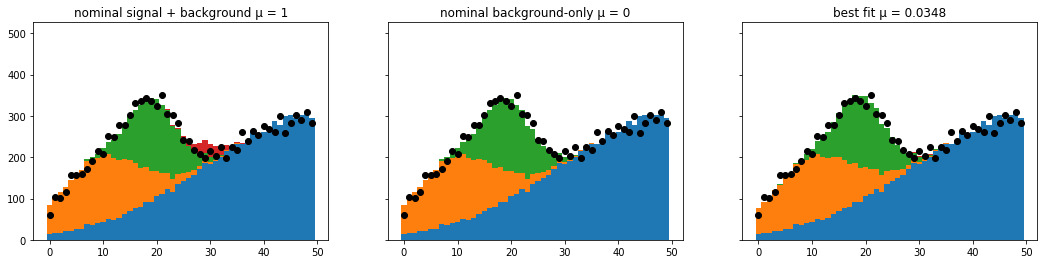

In [10]:
f,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, sharex=True)
f.set_size_inches(18,4)
ax1.set_ylim(0,1.5*np.max(obs_data))
ax1.set_title('nominal signal + background µ = 1')
plot(ax = ax1, **{k: nominal[v] for k,v in par_name_dict.items()})

ax2.set_title('nominal background-only µ = 0')
plot(ax = ax2, **{k: background_only[v] for k,v in par_name_dict.items()})

ax3.set_title('best fit µ = {:.3g}'.format(best_fit[pdf.config.poi_index]))
plot(ax = ax3, **{k: best_fit[v] for k,v in par_name_dict.items()})

## Interval Estimation (Computing Upper Limits on µ)

A common task in the statistical evaluation of High Energy Physics data analyses is the estimation of confidence intervals of parameters of interest. The general strategy is to perform a series of hypothesis tests and then *invert* the tests in order to obtain an interval with the correct coverage properties.

A common figure of merit is a modified p-value, CLs. Here we compute an upper limit based on a series of CLs tests.

In [11]:
def plot_results(ax, test_mus, cls_obs, cls_exp, test_size=0.05):
    ax.plot(mu_tests, cls_obs, c = 'k')
    for i,c in zip(range(5),['k','k','k','k','k']):
        ax.plot(mu_tests, cls_exp[i], c = c, linestyle = 'dotted' if i!=2 else 'dashed')
    ax.fill_between(test_mus,cls_exp[0],cls_exp[-1], facecolor = 'y')
    ax.fill_between(test_mus,cls_exp[1],cls_exp[-2], facecolor = 'g')
    ax.plot(test_mus,[test_size]*len(test_mus), c = 'r')
    ax.set_ylim(0,1)

def invert_interval(test_mus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        y_vals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size, list(reversed(y_vals)), list(reversed(test_mus))))
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size, list(reversed(y_vals)), list(reversed(test_mus)))
    return point05cross

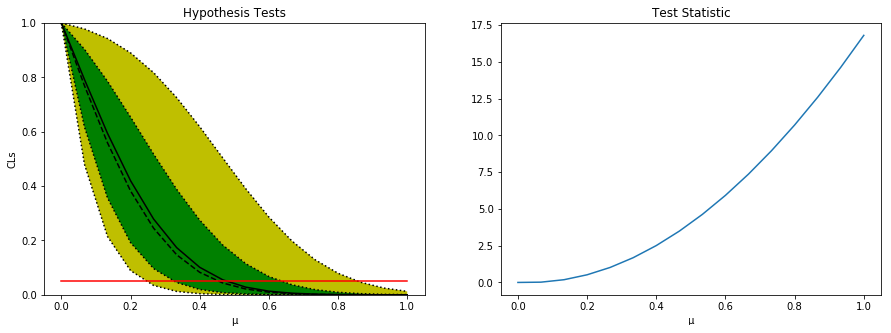

In [12]:
mu_tests = np.linspace(0, 1, 16)
hypo_tests = [pyhf.utils.runOnePoint(mu, data, pdf, pdf.config.suggested_init(), pdf.config.suggested_bounds())
              for mu in mu_tests]

test_stats = np.array([test[0] for test in hypo_tests]).flatten()
cls_obs = np.array([test[-2] for test in hypo_tests]).flatten()
cls_exp = [np.array([test[-1][i] for test in hypo_tests]).flatten() for i in range(5)]

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.set_title('Hypothesis Tests')
ax1.set_ylabel('CLs')
ax1.set_xlabel('µ')
plot_results(ax1, mu_tests, cls_obs, cls_exp)


ax2.set_title('Test Statistic')
ax2.set_xlabel('µ')
ax2.plot(mu_tests,test_stats);

In [13]:
results = invert_interval(mu_tests, cls_obs, cls_exp)

print('Observed Limit: {:.2f}'.format(results['obs']))
print('-----')
for i,n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{}: {:.3f}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results['exp'][i]))

Observed Limit: 0.86
-----
Expected Limit(-2 σ): 0.248
Expected Limit(-1 σ): 0.327
Expected Limit: 0.455
Expected Limit(1 σ): 0.638
Expected Limit(2 σ): 0.858
